## Assignment 2 :  Dig Data Analytics with python

## Name: Darix SAMANI SIEWE

## Introduction

The main objective of this assignment is to learn how to handle a large volume of datasets using the appropriate tools. Usually, there are many tools available to handle these kinds of datasets, such as Hadoop, Apache Spark, Dask, etc. Each tool has its strengths and weaknesses. Due to the large volume of our dataset, the tool that is most suited to our situation is Apache Spark because it is easy to use and has very good documentation, which facilitates its learning curve. It also offers many other APIs that can connect to a variety of tools. The rest of this assignment is organized as follows: Firstly, we need to write a function that can process and clean our dataset using the functionalities of Spark. Finally, we will write some functions to answer questions related to the analysis of our dataset.

# Setup working directories

In this section of our work, we just mount the working direction using google cloud

In [6]:
# Setup global parameters and variables
MISC_PROCESSING_PARAMS = {'distance_threshold': 2, 'min_unique_locs': 2,'datetime_col': 'datetime',
                        'userid': 'user_id','x': 'lon', 'y': 'lat'}
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task-1: Data preprocessing and clean up.

Perfom all the necessary data processing including adding location and date related columns to the dataset. You need to create a function that spits out preprocessed data after taking in raw data in the folder.


In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.functions import date_format
from datetime import datetime, timedelta
from pyspark.sql.functions import to_timestamp, to_date, col
import random
import pandas

def preprocess_cdrs_using_spark(file_or_folder=None, number_of_users_to_sample=None,
                                output_csv=None, date_format='yyyyMMddHHmmss',
                                debug_mode=True, loc_file=None, save_to_csv=False):
    """
    In this function, we perfom some basic preprocessing such as below:
    1. rename columns
    2. change some data types
    3. Add location details
    Eventually, we will sample the data to use for our analysis
    :param data_folder:
    :param output_csv_for_sample_users:
    :return:
    """

    # create a SparkSession object
    spark = SparkSession.builder.appName("DataProcessing").config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .getOrCreate()


    df = spark.read.csv(file_or_folder, header=True)


    df = df.repartition(10)


    df = df.withColumnRenamed("cdr type", "cdrType").withColumnRenamed("cdr datetime", "cdrDatetime")\
    .withColumnRenamed("call duration", "callDuration").withColumnRenamed("last calling cellid", "cellId")\
    .withColumnRenamed("user_id", "phoneNumber")
    df = df.withColumn("cellId", col("cellId").cast("int"))


    df = df.drop("cdrType")

    df = df.withColumn("datetime", to_timestamp(col("cdrDatetime"), datetime_fmt))
    df = df.withColumn("date", to_date(col("cdrDatetime"), datetime_fmt))

    #df.show()

    df = df.filter(df.phoneNumber.isNotNull())


    dfLoc = pandas.read_csv(loc_file)

    dfLoc.rename(columns={'cell_id': 'cellId'}, inplace=True)

    sdfLoc = spark.createDataFrame(dfLoc)
    print("2")
    #sdfLoc.show()
    df_join = df.join(sdfLoc, on="cellId", how='inner')

    df_join = df_join.filter(df.cellId.isNotNull())

    all_users = df_join.select("phoneNumber").distinct().rdd.flatMap(lambda x: x).collect()


    random_user_numbers = random.choices(all_users, k=number_of_users_to_sample)

    df.cache()

    dfu = df_join.filter(df.phoneNumber.isin(random_user_numbers))

    #dfu.show()
    if save_to_csv:
        dfu.write.csv(output_csv, header=True, mode="overwrite")
    else:
        return dfu

In [8]:
import os
from pathlib import Path


DATA_DIR = "/content/drive/MyDrive"  # Example base directory

cdrs_dir = os.path.join(DATA_DIR, "simulated_cdrs")
loc_file = os.path.join(DATA_DIR, "simulated_locs.csv")
num_users = 100000
debug = True
datetime_fmt = "yyyyMMddHHmmss"

dfu = preprocess_cdrs_using_spark(file_or_folder=cdrs_dir, number_of_users_to_sample=num_users,
                                output_csv=None, date_format='yyyyMMddHHmmss',
                                debug_mode=debug, loc_file=loc_file, save_to_csv=False)



2


### Task-2. Perform data exploration to generate the following statistics and tables.
 - Total number of days in the dataset
 - Mean and median  number of calls per user.

In order to answer the question of this section we just write the function to acheive that and at the ned we just print the result and plot the distribution of the user by call

Total number of days in the dataset: 15
Mean number of calls per user: 15.538631125363263
Median number of calls per user: 4.0


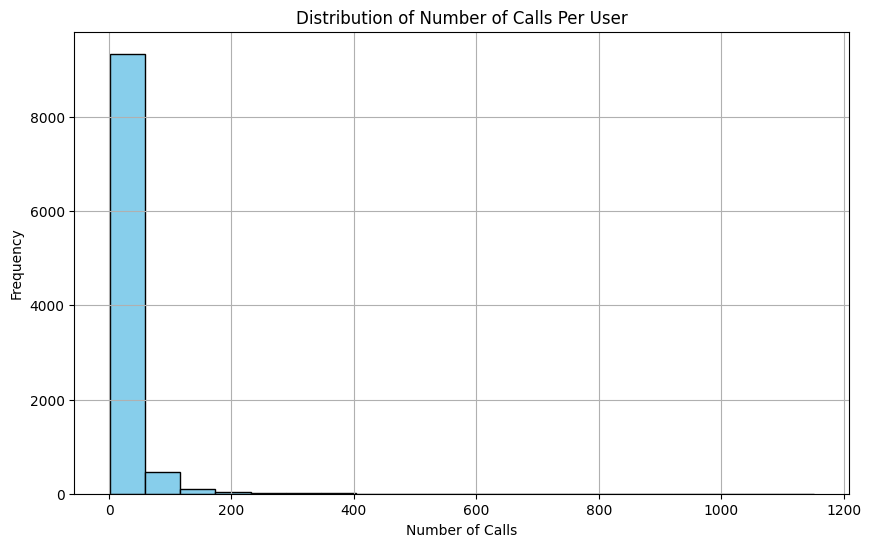

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import to_date, col, count, avg, expr
from pyspark.sql.window import Window
from pyspark.sql.functions import col, countDistinct, count, mean

## this sample file help us the write all of the rest of the part before try on all dataset
## the propulse of the file is to help us to write function before try on full dataset
## because trying on full dataset, take us many time.
long_sample_file = "/content/drive/MyDrive/simulated_cdrs_processed/part-00026-311c56b8-c08c-4fb6-a4a8-1d45d729748f-c000.csv"

def function_task_2(df, out_stats):

  distinct_dates_count = df.select("date").distinct().count()


  ## aggregate by user and count the number of cell_id and chnage the name
  calls_per_user = df.groupBy("phoneNumber").agg(count("cellId").alias("num_calls"))

  ### means calls
  mean_calls = calls_per_user.select(mean("num_calls")).collect()[0][0]




  calls_list = [row['num_calls'] for row in calls_per_user.collect()]
  median_calls = np.median(calls_list)

  print(f"Total number of days in the dataset: {distinct_dates_count}")
  print(f"Mean number of calls per user: {mean_calls}")
  print(f"Median number of calls per user: {median_calls}")

  ## historgram of number of call by user
  plt.figure(figsize=(10,6))
  plt.hist(calls_list, bins=20, color='skyblue', edgecolor='black')
  plt.title('Distribution of Number of Calls Per User')
  plt.xlabel('Number of Calls')
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

spark = SparkSession.builder.appName("DataProcessing").getOrCreate()
df_spark = spark.read.csv(long_sample_file, header=True)
df_spark.withColumn("datetime", to_timestamp("datetime", "yyyy-MM-dd HH:mm:ss"))
df_spark.withColumn("date", to_timestamp("date", "yyyy-MM-dd"))

## call the function of task 2
function_task_2(dfu, "out_stats")

# Park 3 : User mobility patterns.

 - Create and run function to create individual user mobility attributes (e.g., number of location visited per day). This function can return a function where each row is single user and columns include user_id(important to not that this column has been replaced by phoneNumber during our processing and cleaning function in the first step)

To answer this question, we calculate the number of distinct locations (latitude, longitude) each user visited on each day. A simple approach is to first aggregate the data by user and day, then count the number of unique locations (latitude and longitude) visited by the user on that specific day.

- Explore correlation between avg_Rg (mean radius of gyration)  and avg_locs_per_day. Please report the correlation results appropriately with a plot showing the correlation coefficient

The radius of gyration is a measure of how spread out the user's locations are. The formula for Rg is:

$$
Rg = \sqrt{\frac{1}{N} \sum_{i=1}^{N}(x_i - \bar{x})^2 + (y_i - \bar{y})^2}
$$

where $x_i$, $y_i$ are the coordinates of user on a specific day and $\bar{x}$ and $\bar{y}$ are the means  coodinates for that user on that day.





## Define functions to generate user attributes

To achive our goal in this section we defined three function, just follow the principle divide and conquer beacause each function is responsiblity for a specific task. This approach make our more readatable and reproductible.

Correlation coefficient between avg_Rg and avg_locs_per_day: 0.35107099261522995


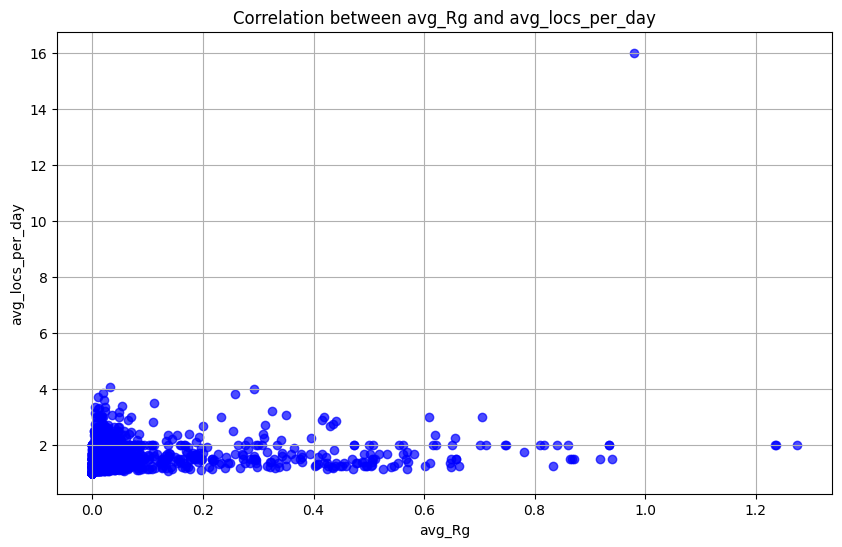

In [5]:
from pyspark.sql import functions as F


def calculate_locs_per_day(df):
    """
    Function to calculate the number of distinct locations visited per day for each user.
    Input: Spark DataFrame with columns 'phoneNumber', 'date', 'lat', 'lon'
    Output: Spark DataFrame with columns 'phoneNumber', 'avg_locs_per_day'
    """

    locs_per_day = df.groupBy("phoneNumber", "date").agg(countDistinct("lat", "lon").alias("num_locs_per_day"))
    locs_per_day_avg = locs_per_day.groupBy("phoneNumber").agg(avg("num_locs_per_day").alias("avg_locs_per_day"))
    return locs_per_day_avg

def calculate_radius_of_gyration(df):
    """
    Function to calculate the mean radius of gyration for each user.
    input: Spark DataFrame with columns 'phoneNumber', 'date', 'lat', 'lon'
    Output: Spark DataFrame with columns 'phoneNumber', 'avg_Rg'
    """

    df = df.withColumn("x", col("lat")).withColumn("y", col("lon"))

    ## calcalte the means coordinates for each user in specifiqc days.

    user_coords = df.groupBy("phoneNumber", "date").agg(
        F.avg("x").alias("mean_x"),
        F.avg("y").alias("mean_y")
    )

    # inner join find the intersection on phoneNumber and date  between  two dataframe
    df_with_means = df.join(user_coords, on=["phoneNumber", "date"], how="inner")

    # this line help us to calcalute the distance form the mean
    df_with_means = df_with_means.withColumn(
        "distance",
        (col("x") - col("mean_x"))**2 + (col("y") - col("mean_y"))**2
    )

    # Calculate the Rg(radius of gyration) for each phoneNumber (mean of the distances per user per day)
    user_rg = df_with_means.groupBy("phoneNumber").agg(
        F.mean("distance").alias("mean_distance")
    )

    # Rg(radius of gyration) is the square root of the mean distance
    user_rg = user_rg.withColumn("avg_Rg", F.sqrt(col("mean_distance")))
    return user_rg

def save_user_mobility_attributes(df):
    """
    Function to calculate user mobility attributes (number of locations per day and Rg),
    then save them to a CSV file.
    input: Spark DataFrame with columns 'phoneNumber', 'date', 'lat', 'lon'
    Output: Spark DataFrame with columns 'phoneNumber', 'avg_locs_per_day', 'avg_Rg'
    """

    locs_per_day_avg = calculate_locs_per_day(df)


    radius_of_gyration = calculate_radius_of_gyration(df)


    user_mobility = locs_per_day_avg.join(radius_of_gyration, on="phoneNumber")


    user_mobility_pd = user_mobility.toPandas()
    user_mobility_pd.to_csv('user_mobility_attributes.csv', index=False)

    return user_mobility_pd


def explore_correlation(user_mobility):
    """
    Function to explore the correlation between avg_Rg and avg_locs_per_day,
    then plot the correlation using a scatter plot.
    input: Spark DataFrame with columns 'phoneNumber', 'avg_locs_per_day', 'avg_Rg'
    output: None
    """
    # Calculate the correlation
    correlation = user_mobility['avg_Rg'].corr(user_mobility['avg_locs_per_day'])
    print(f"Correlation coefficient between avg_Rg and avg_locs_per_day: {correlation}")

    # Plot the scatter plot
    plt.figure(figsize=(10,6))
    plt.scatter(user_mobility['avg_Rg'], user_mobility['avg_locs_per_day'], alpha=0.7, color='blue')
    plt.title("Correlation between avg_Rg and avg_locs_per_day")
    plt.xlabel("avg_Rg")
    plt.ylabel("avg_locs_per_day")
    plt.grid(True)
    plt.show()


user_mobility = save_user_mobility_attributes(dfu)


explore_correlation(user_mobility)

### Task-4. What large dataset challenges did you face and how did you solve them. Please explain the decisions you made and why you made them. For example, if you sampled the data, how much of the data did you sample?


Throughout this assignment, we encountered challenges related to processing large datasets. Using tools like PySpark helped speed up the process of loading and processing large amounts of data, providing better performance than traditional tools like Dask and Pandas.

One key recommendation is to sample a smaller portion of the dataset before loading the entire dataset. This approach allowed us to develop and test our functions and code efficiently, ensuring the logic was correct before scaling up. Sampling helped us save time and improve productivity, as running the full dataset without proper validation would have taken a significant amount of time and resources, especially since we didn’t have access to high-performance infrastructure (HPI) to handle the complete dataset.

By initially testing on a smaller sample, we validated and optimized our processes before running the full dataset, reducing the overall time spent during the analysis.

For the sample of our data, after performing the join operation, we randomly selected 10,000 users from the dataset and retrieved their information. The reasons for choosing this value are: firstly, we don't have the computing resources to choose a very large number, as we are using PySpark on Google Colab, and secondly, because this sample size is sufficient to answer some of the questions related to the dataset.

Finally, at the end of our study, we observed that the choice of sample size can affect our results. To validate some of the findings, we need to investigate the statistical properties of some of the results obtained during this study. The purpose of studying the statistical properties of our results is to check how much the results would be affected if we repeated the experiment in the real world or chose the sample randomly.
